### 导入

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # 导入 numpy
from scipy.stats import kruskal
from matplotlib import font_manager
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
font_files = font_manager.findSystemFonts(fontpaths='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)


### 统计基因表达和loop数量		
/cluster/home/tmp/GBM/HiC/hubgene/new/pre.sh 

In [ ]:
# 读取 TPM_avg.txt 文件
tpm_avg_file = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_fixed.txt"
tpm_avg_df = pd.read_csv(tpm_avg_file, sep='\t')

# 获取当前文件夹下所有 _G.bedpe 文件
bedpe_files = glob.glob("/cluster/home/futing/Project/GBM/HiC/hubgene/new/*_G.bedpe")  # 当前文件夹中的所有 _G.bedpe 文件

# 遍历每个 .bedpe 文件并统计基因出现次数
for bedpe_file in bedpe_files:
    # 获取文件名（去掉路径和扩展名）
    filename = bedpe_file.split("/")[-1].replace("_G.bedpe", "")
    
    # 读取当前 _G.bedpe 文件
    bedpe_df = pd.read_csv(bedpe_file, sep='\t', header=None)
    
    # 提取第7列（基因名字列）
    genes_in_bedpe = bedpe_df[6].value_counts()  # 基因名字列是第7列（索引为6）

    # 统一基因名格式，去除空格并转为小写
    tpm_avg_df['Gene'] = tpm_avg_df['Gene'].str.strip().str.lower()
    genes_in_bedpe.index = genes_in_bedpe.index.str.strip().str.lower()  # 清理 .bedpe 文件中的基因名
    
    # 创建一个新的列，列名为文件名，填入每个基因的出现次数
    tpm_avg_df[filename + "_G"] = tpm_avg_df['Gene'].map(genes_in_bedpe).fillna(0).astype(int)

# 保存更新后的 TPM_avg.txt 文件
output_file = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
tpm_avg_df.to_csv(output_file, sep='\t', index=False)

print(f"基因出现次数已添加到 {output_file} 文件.")


基因出现次数已添加到 /cluster/home/tmp/GBM/HiC/hubgene/new/TPM_avg_updated.txt 文件.


### 每个loop 包含基因数

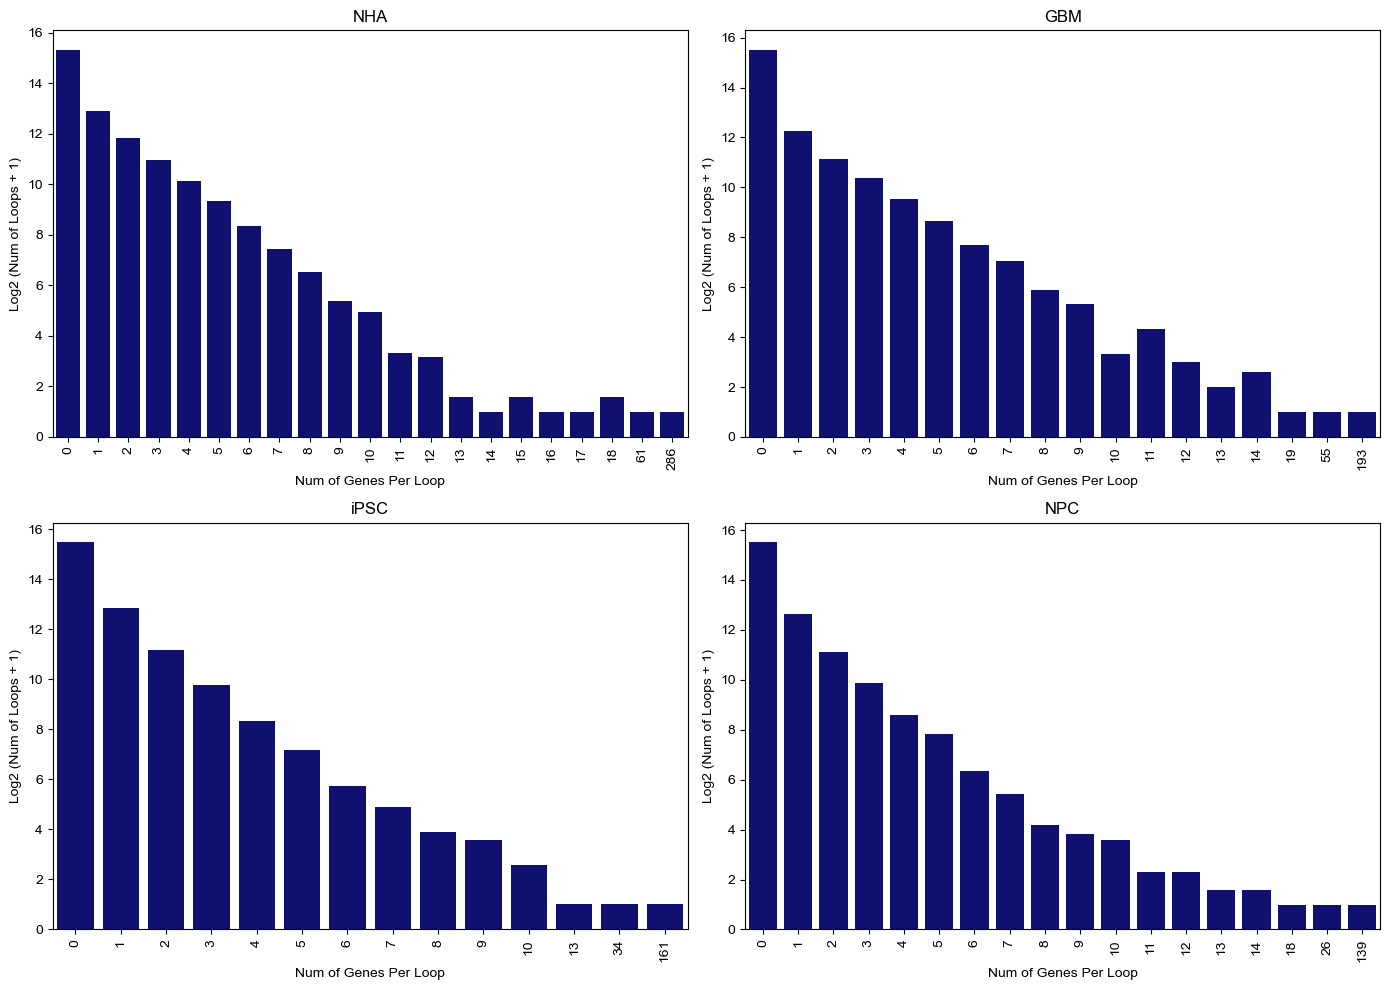

In [7]:

# 读取文件
file_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
df = pd.read_csv(file_path, sep='\t')

# 获取第7到第10列的列名
columns_to_plot = df.columns[6:10]

# 创建 2x2 的子图
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 遍历第7到第10列，分别绘制每列的基因计数
for i, col in enumerate(columns_to_plot):
    # 获取当前的子图
    ax = axs[i//2, i%2]
    
    # 统计当前列基因出现的次数
    gene_counts = df[col].value_counts()
    
    # 对 gene_counts 进行 log2(x+1) 转换
    gene_counts_log2 = np.log2(gene_counts + 1)
    
    # 绘制柱状图
    sns.barplot(x=gene_counts.index, y=gene_counts_log2.values, ax=ax, color='navy')
    
    # 设置每个子图的标题和标签
    title = col.replace('_merged_G', '')  # 或 col.split('_merged_G')[0]
    ax.set_title(f"{title}")
    ax.set_xlabel('Num of Genes Per Loop')
    ax.set_ylabel('Log2 (Num of Loops + 1)')  # 修改纵轴标签，反映 log2 转换
    ax.tick_params(axis='x', rotation=90)  # 旋转 x 轴标签，防止重叠

# 调整布局以防止子图重叠
plt.tight_layout()

# 显示图表
plt.savefig("/cluster/home/futing/Project/GBM/HiC/hubgene/new/num_loop.pdf", format='pdf')

# 显示图表
plt.show()


### 受更多loop调控，基因表达更高

#### GBM

In [21]:
df.head()

,Gene,GBM,iPSC,NHA,NPC,pHGG,NHA_merged_G,GBM_merged_G,iPSC_merged_G,NPC_merged_G,log2_TPM_plus_1,loop_category
0,5_8s_rrna,13.442407,216.616667,1926.973333,119.586667,494.70625,0,0,0,0,3.852239,0
1,5s_rrna,0.016711,0.000000,0.663333,0.000000,0.45625,2,0,1,4,0.023910,0
2,7sk,4.215215,0.000000,2.036667,0.000000,18.14250,8,5,1,2,2.382727,2+
3,a1bg,18.205298,21.623333,3.533333,19.563333,7.42125,0,0,0,0,4.263432,0
4,a1bg-as1,4.913878,2.350000,2.916667,4.333333,5.20875,0,0,1,0,2.564104,0


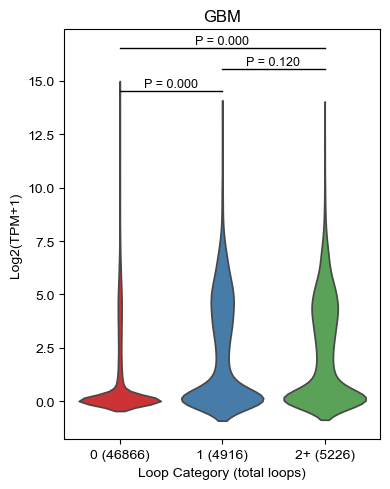

In [ ]:


# 读取 TPM_avg_updated.txt 文件
file_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
df = pd.read_csv(file_path, sep='\t')

# 添加 log2(TPM+1) 列
df['log2_TPM_plus_1'] = np.log2(df['GBM'] + 1)

# 将 loop 数量分成三类：0，1，>2
df['loop_category'] = pd.cut(df['GBM_merged_G'], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])

# 计算每个类别的数量
loop_counts = df['loop_category'].value_counts().reindex(['0', '1', '2+'])

# 创建绘图
plt.figure(figsize=(4,5))

# 绘制箱线图，横轴为 loop 数量，纵轴为 log2(TPM+1)
sns.violinplot(data=df, x='loop_category', y='log2_TPM_plus_1',palette='Set1',hue='loop_category',
            order=['0', '1', '2+'],inner=None)

# 在横轴标签上添加括号中的数量
loop_labels = [f'{label} ({loop_counts[label]})' for label in loop_counts.index]
plt.xticks(ticks=range(len(loop_labels)), labels=loop_labels)


# --------- testing
# 进行 Kruskal-Wallis H 检验
group_0 = df[df['loop_category'] == '0']['log2_TPM_plus_1']
group_1 = df[df['loop_category'] == '1']['log2_TPM_plus_1']
group_2 = df[df['loop_category'] == '2+']['log2_TPM_plus_1']

# 进行两两比较
p_01 = kruskal(group_0, group_1).pvalue
p_02 = kruskal(group_0, group_2).pvalue
p_12 = kruskal(group_1, group_2).pvalue

# 设置不同的 y_position 来避免重叠
y_position_01 = max(df['log2_TPM_plus_1'])  # 组 0 和 1 比较的 p 值位置
y_position_02 = max(df['log2_TPM_plus_1']) + 2  # 组 0 和 2 比较的 p 值位置
y_position_12 = max(df['log2_TPM_plus_1']) + 1  # 组 1 和 2 比较的 p 值位置

# 连接组 0 和组 1
plt.plot([0, 1], [y_position_01, y_position_01], color='black', lw=1)
# 连接组 0 和组 2
plt.plot([0, 2], [y_position_02, y_position_02], color='black', lw=1)
# 连接组 1 和组 2
plt.plot([1, 2], [y_position_12, y_position_12], color='black', lw=1)

# 在每个线条上方标注 p 值
plt.text(0.5, y_position_01 + 0.05, f'P = {p_01:.3f}', ha='center', va='bottom', fontsize=9, color='black')
plt.text(1.5, y_position_12 + 0.05, f'P = {p_12:.3f}', ha='center', va='bottom', fontsize=9, color='black')
plt.text(1, y_position_02 + 0.05, f'P = {p_02:.3f}', ha='center', va='bottom', fontsize=9, color='black')

# 设置标题和标签
plt.title("GBM")
plt.xlabel("Loop Category (total loops)")
plt.ylabel("Log2(TPM+1)")

output_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/GBMRNA_nloop.pdf"
plt.tight_layout()  # 调整布局
plt.savefig(output_path, format='pdf')  # 保存为 PDF



#### 4 cells

In [4]:
df.head()

,Gene,GBM,iPSC,NHA,NPC,pHGG,NHA_merged_G,GBM_merged_G,iPSC_merged_G,NPC_merged_G,log2_TPM_plus_1,loop_category
0,5_8s_rrna,13.442407,216.616667,1926.973333,119.586667,494.70625,0,0,0,0,6.913927,0
1,5s_rrna,0.016711,0.000000,0.663333,0.000000,0.45625,2,0,1,4,0.000000,2+
2,7sk,4.215215,0.000000,2.036667,0.000000,18.14250,8,5,1,2,0.000000,2+
3,a1bg,18.205298,21.623333,3.533333,19.563333,7.42125,0,0,0,0,4.362002,0
4,a1bg-as1,4.913878,2.350000,2.916667,4.333333,5.20875,0,0,1,0,2.415037,0


/tmp/ipykernel_65030/194131259.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(loop_labels)
/tmp/ipykernel_65030/194131259.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(loop_labels)
/tmp/ipykernel_65030/194131259.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(loop_labels)
/tmp/ipykernel_65030/194131259.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(loop_labels)


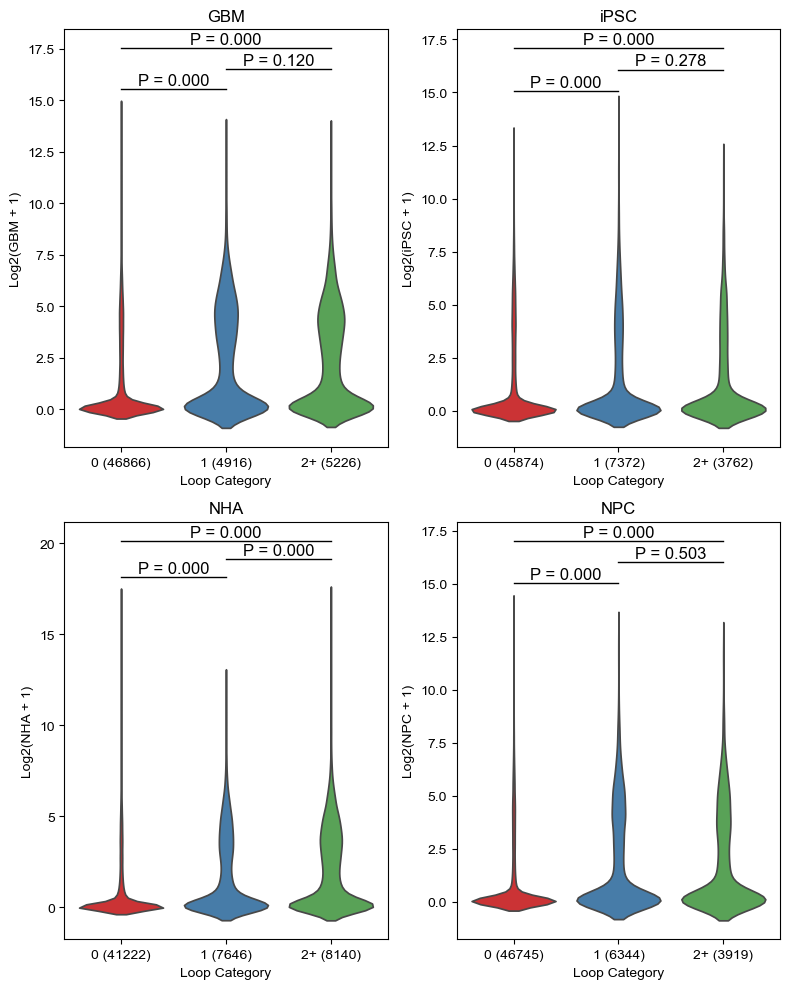

In [5]:

# 读取 TPM_avg_updated.txt 文件
file_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
df = pd.read_csv(file_path, sep='\t')

# 创建一个列表保存每组需要的列名
tpm_columns = ['GBM', 'iPSC', 'NHA', 'NPC']
loop_columns = ['GBM_merged_G', 'iPSC_merged_G', 'NHA_merged_G', 'NPC_merged_G']

# 设置绘图区域
fig, axes = plt.subplots(2, 2, figsize=(8, 10))  # 创建 2x2 网格的子图

# 遍历 tpm_columns 和 loop_columns 绘制每个子图
for i, (tpm_col, loop_col) in enumerate(zip(tpm_columns, loop_columns)):
    # 添加 log2(TPM+1) 列
    df['log2_TPM_plus_1'] = np.log2(df[tpm_col] + 1)

    # 将 loop 数量分成三类：0，1，>2
    df['loop_category'] = pd.cut(df[loop_col], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])

    # 计算每个类别的数量
    loop_counts = df['loop_category'].value_counts()

    # 选择对应的子图位置
    ax = axes[i // 2, i % 2]  # 计算位置，2x2 网格

    # 绘制箱线图，横轴为 loop 数量，纵轴为 log2(TPM+1)
    sns.violinplot(data=df, x='loop_category', y='log2_TPM_plus_1', ax=ax, 
                   hue_order=['0', '1', '2+'],hue='loop_category',palette='Set1',inner=None)

    # 在横轴标签上添加括号中的数量
    loop_labels = [f'{label} ({loop_counts.get(label, 0)})' for label in ['0', '1', '2+']]
    ax.set_xticklabels(loop_labels)

    # 设置标题和标签
    ax.set_title(f"{tpm_col}")
    ax.set_xlabel("Loop Category")
    ax.set_ylabel(f"Log2({tpm_col} + 1)")

    # 进行 Kruskal-Wallis H 检验
    group_0 = df[df['loop_category'] == '0']['log2_TPM_plus_1']
    group_1 = df[df['loop_category'] == '1']['log2_TPM_plus_1']
    group_2 = df[df['loop_category'] == '2+']['log2_TPM_plus_1']

    # 进行两两比较
    p_01 = kruskal(group_0, group_1).pvalue
    p_02 = kruskal(group_0, group_2).pvalue
    p_12 = kruskal(group_1, group_2).pvalue

    # 设置不同的 y_position 来避免重叠
    y_position_01 = max(df['log2_TPM_plus_1']) + 1  # 组 0 和 1 比较的 p 值位置
    y_position_02 = max(df['log2_TPM_plus_1']) + 3  # 组 0 和 2 比较的 p 值位置
    y_position_12 = max(df['log2_TPM_plus_1']) + 2  # 组 1 和 2 比较的 p 值位置

    # 连接组 0 和组 1
    ax.plot([0, 1], [y_position_01, y_position_01], color='black', lw=1)
    # 连接组 0 和组 2
    ax.plot([0, 2], [y_position_02, y_position_02], color='black', lw=1)
    # 连接组 1 和组 2
    ax.plot([1, 2], [y_position_12, y_position_12], color='black', lw=1)

    # 在每个线条上方标注 p 值
    ax.text(0.5, y_position_01 + 0.05, f'P = {p_01:.3f}', ha='center', va='bottom', fontsize=12, color='black')
    ax.text(1.5, y_position_12 + 0.05, f'P = {p_12:.3f}', ha='center', va='bottom', fontsize=12, color='black')
    ax.text(1, y_position_02 + 0.05, f'P = {p_02:.3f}', ha='center', va='bottom', fontsize=12, color='black')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()


#### GBMvsiPSC

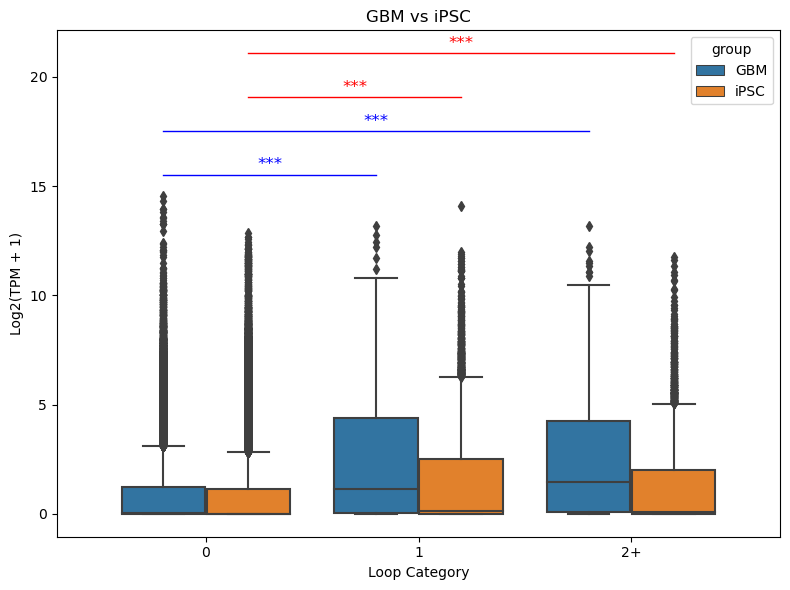

In [ ]:

# 读取 TPM_avg_updated.txt 文件
file_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
df = pd.read_csv(file_path, sep='\t')

# 只保留 GBM 和 iPSC 相关列
tpm_columns = ['GBM', 'iPSC']
loop_columns = ['GBM_merged_G', 'iPSC_merged_G']

# 设置绘图区域
fig, ax = plt.subplots(figsize=(8, 6))  # 单个图

# 创建空的列表来保存绘图所需的数据
plot_data = []

# 遍历 tpm_columns 和 loop_columns 来整理数据
for tpm_col, loop_col in zip(tpm_columns, loop_columns):
    # 添加 log2(TPM+1) 列
    df['log2_TPM_plus_1'] = np.log2(df[tpm_col] + 1)

    # 将 loop 数量分成三类：0，1，>2
    df['loop_category'] = pd.cut(df[loop_col], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])
    
    # 构建用于绘图的 DataFrame
    temp_df = df[['log2_TPM_plus_1', 'loop_category']].copy()
    temp_df['group'] = tpm_col  # 添加分组信息（GBM 或 iPSC）
    
    # 将 temp_df 添加到 plot_data 列表
    plot_data.append(temp_df)

# 合并所有的 plot_data
plot_df = pd.concat(plot_data)

# 绘制箱线图，横轴为 loop_category，纵轴为 log2(TPM+1)，分组为 'group'
sns.boxplot(data=plot_df, x='loop_category', y='log2_TPM_plus_1', hue='group', order=['0', '1', '2+'], ax=ax)

# 设置标题和标签
ax.set_title("GBM vs iPSC")
ax.set_xlabel("Loop Category")
ax.set_ylabel("Log2(TPM + 1)")

# 计算 p 值的函数
def calculate_p_values(df, group_col, value_col):
    p_values = []
    for cat1 in ['0', '1', '2+']:
        for cat2 in ['0', '1', '2+']:
            if cat1 < cat2:
                group1 = df[df[group_col] == cat1][value_col]
                group2 = df[df[group_col] == cat2][value_col]
                stat, p_value = kruskal(group1, group2)
                p_values.append(((cat1, cat2), p_value))
    return p_values

# 用于显示 p 值的 y 位置偏移量（分别针对 GBM 和 iPSC 设置）
y_offsets_gbm = {
    ('0', '1'): 1,  # GBM 比较
    ('0', '2+'): 3,
    ('1', '2+'): 2,
}

y_offsets_ipsc = {
    ('0', '1'): 5,  # iPSC 比较
    ('0', '2+'): 7,
    ('1', '2+'): 6
}

# 修改 add_stat_annotation 函数，以便分别为 GBM 和 iPSC 添加不同的 y_position
def add_stat_annotation(ax, pvals, y_offsets, positions, label_offset=0.1, color='black', group='GBM'):
    """
    添加 P 值的标注和连线，分别处理 GBM 和 iPSC 的位置。
    :param ax: 轴对象
    :param pvals: P 值数据
    :param y_offsets: 每个类别之间的 y 轴偏移量
    :param positions: 每个类别在 x 轴上的位置
    :param label_offset: 标签的偏移量
    :param color: 线条和文本的颜色
    :param group: 'GBM' 或 'iPSC'，用于选择组的纵向位置
    """
    for (i, j), p in pvals:
        # 根据 p 值决定是否显示星号
        if p < 0.001:
            star = '***'
        elif p < 0.01:
            star = '**'
        elif p < 0.05:
            star = '*'
        else:
            continue  # 如果不显著，跳过当前循环
        
        # 根据组的不同，设置 y 位置
        group_data = plot_df[plot_df['group'] == group]
        y_position = group_data['log2_TPM_plus_1'].max() + y_offsets[(i, j)]  # 根据组的最大值来设置 y 位置

        # 添加星号标注
        ax.text((positions[i] + positions[j]) / 2, y_position + label_offset, star,
                ha='center', va='bottom', fontsize=12, color=color)
        
        # 添加连线：确保连线的起点和终点在柱子上方
        ax.plot([positions[i], positions[j]], [y_position, y_position], color=color, lw=1)

# 设置每个分类的位置，区分 GBM 和 iPSC 的位置
positions_gbm = {'0': -0.2, '1': 0.8, '2+': 1.8}  # GBM 在 x 轴上的位置，偏移
positions_ipsc = {'0': 0.2, '1': 1.2, '2+': 2.2}  # iPSC 在 x 轴上的位置，偏移

# 计算 P 值
gbm_pvals = calculate_p_values(plot_df[plot_df['group'] == 'GBM'], 'loop_category', 'log2_TPM_plus_1')
ipsc_pvals = calculate_p_values(plot_df[plot_df['group'] == 'iPSC'], 'loop_category', 'log2_TPM_plus_1')

# 添加 GBM 的 p 值标注
add_stat_annotation(ax, gbm_pvals, y_offsets_gbm, positions_gbm, label_offset=0.1, color='blue', group='GBM')  # GBM

# 添加 iPSC 的 p 值标注
add_stat_annotation(ax, ipsc_pvals, y_offsets_ipsc, positions_ipsc, label_offset=0.1, color='red', group='iPSC')  # iPSC

# 显示图形
plt.tight_layout()
plt.show()


#### GBMvsCtrl

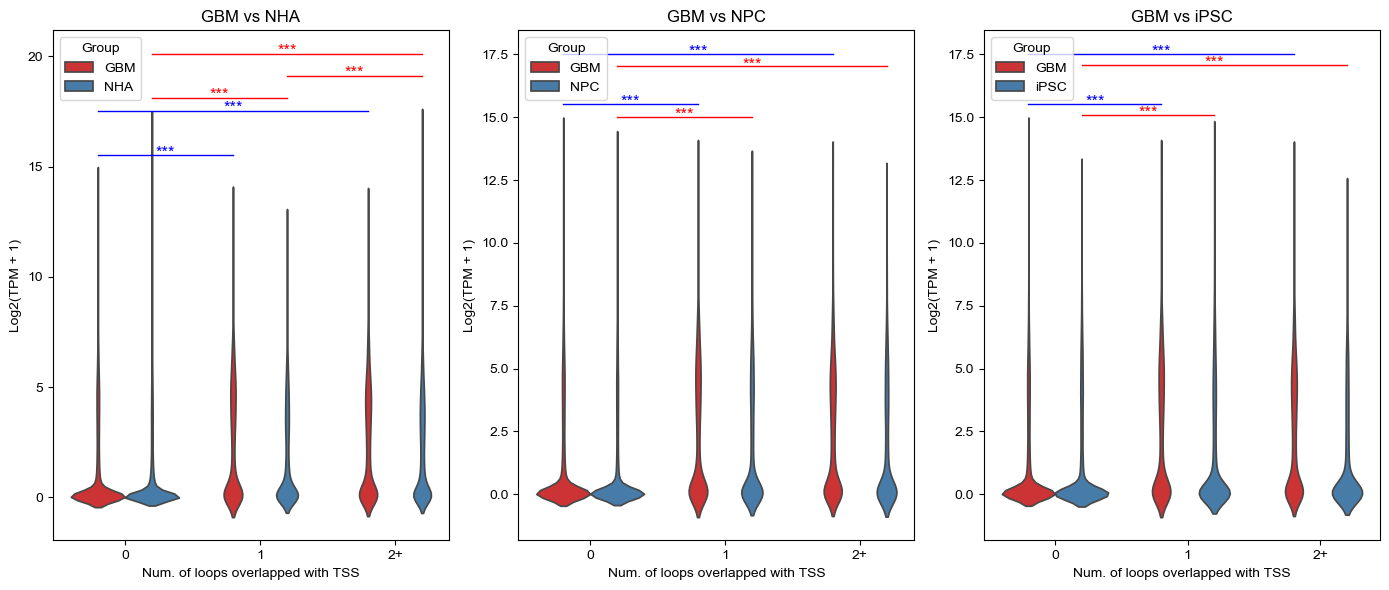

In [10]:

plt.rcParams['pdf.fonttype'] = 42
# 读取数据
file_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/TPM_avg_updated.txt"
df = pd.read_csv(file_path, sep='\t')


# 需要比较的列
tpm_columns = ['GBM', 'NHA', 'NPC', 'iPSC']
loop_columns = ['GBM_merged_G', 'NHA_merged_G', 'NPC_merged_G', 'iPSC_merged_G']

# 设置绘图区域：1行3列的画布
fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # 单行三个图

# 绘制每一个比较图
comparisons = [('GBM', 'NHA'), ('GBM', 'NPC'), ('GBM', 'iPSC')]

for idx, (group1, group2) in enumerate(comparisons):
    ax = axes[idx]  # 获取对应的子图
    
    # 创建空的列表来保存绘图所需的数据
    plot_data = []

    # 遍历 tpm_columns 和 loop_columns 来整理数据
    for tpm_col, loop_col in zip([group1, group2], [group1 + '_merged_G', group2 + '_merged_G']):
        # 添加 log2(TPM+1) 列
        df['log2_TPM_plus_1'] = np.log2(df[tpm_col] + 1)

        # 将 loop 数量分成三类：0，1，>2
        df['loop_category'] = pd.cut(df[loop_col], bins=[-1, 0, 1, float('inf')], labels=['0', '1', '2+'])
        
        # 构建用于绘图的 DataFrame
        temp_df = df[['log2_TPM_plus_1', 'loop_category']].copy()
        temp_df['Group'] = tpm_col  # 添加分组信息（GBM 或 iPSC）
        
        # 将 temp_df 添加到 plot_data 列表
        plot_data.append(temp_df)

    # 合并所有的 plot_data
    plot_df = pd.concat(plot_data)

    # 绘制箱线图
    # sns.boxplot(data=plot_df, x='loop_category', y='log2_TPM_plus_1', hue='Group', order=['0', '1', '2+'], ax=ax)
    sns.violinplot(data=plot_df, x='loop_category', y='log2_TPM_plus_1', ax=ax, 
                    order=['0', '1', '2+'],hue='Group',palette='Set1',inner=None)

    # 设置标题和标签
    ax.set_title(f"{group1} vs {group2}")
    ax.set_xlabel("Num. of loops overlapped with TSS")
    ax.set_ylabel("Log2(TPM + 1)")

    # 计算 p 值的函数
    def calculate_p_values(df, group_col, value_col):
        p_values = []
        for cat1 in ['0', '1', '2+']:
            for cat2 in ['0', '1', '2+']:
                if cat1 < cat2:
                    group1 = df[df[group_col] == cat1][value_col]
                    group2 = df[df[group_col] == cat2][value_col]
                    stat, p_value = kruskal(group1, group2)
                    p_values.append(((cat1, cat2), p_value))
        return p_values

    # 用于显示 p 值的 y 位置偏移量（分别针对每个比较设置）
    y_offsets = {
        ('0', '1'): 1,
        ('0', '2+'): 3,
        ('1', '2+'): 2,
    }

    # 修改 add_stat_annotation 函数，以便分别为每个比较添加 p 值标注
    def add_stat_annotation(ax, pvals, y_offsets, positions, label_offset=0.001, color='black', group='GBM'):
        """
        添加 P 值的标注和连线，分别处理不同的组
        """
        for (i, j), p in pvals:
            # 根据 p 值决定是否显示星号
            if p < 0.001:
                star = '***'
            elif p < 0.01:
                star = '**'
            elif p < 0.05:
                star = '*'
            else:
                continue  # 如果不显著，跳过当前循环

            # 根据组的不同，设置 y 位置
            group_data = plot_df[plot_df['Group'] == group]
            y_position = group_data['log2_TPM_plus_1'].max() + y_offsets[(i, j)]  # 根据组的最大值来设置 y 位置

            # 添加星号标注
            ax.text((positions[i] + positions[j]) / 2, y_position + label_offset - 0.25, star,
                    ha='center', va='bottom', fontsize=12, color=color)

            # 添加连线
            ax.plot([positions[i], positions[j]], [y_position, y_position], color=color, lw=1)

    # 计算 P 值
    group1_pvals = calculate_p_values(plot_df[plot_df['Group'] == group1], 'loop_category', 'log2_TPM_plus_1')
    group2_pvals = calculate_p_values(plot_df[plot_df['Group'] == group2], 'loop_category', 'log2_TPM_plus_1')

    # 设置每个分类的位置
    positions_group1 = {'0': -0.2, '1': 0.8, '2+': 1.8}
    positions_group2 = {'0': 0.2, '1': 1.2, '2+': 2.2}

    # 添加 p 值标注
    add_stat_annotation(ax, group1_pvals, y_offsets, positions_group1, label_offset=0.005, color='blue', group=group1)
    add_stat_annotation(ax, group2_pvals, y_offsets, positions_group2, label_offset=0.005, color='red', group=group2)

# 显示图形
output_path = "/cluster/home/futing/Project/GBM/HiC/hubgene/new/loop_exp_comparison.pdf"
plt.tight_layout()
plt.savefig(output_path, format='pdf')  # 保存为 PDF
plt.show()
